# ECE1512 Project A - Section 6
## Extension A: Multi-Resolution Selective Scanning (MRSS)
Efficiency Toy Profiling (SSM-like Operator Proxy)


In [1]:
import os, time, math, csv, random, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

# Basic environment setup
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


### Model Definitions (Proxy for SSM/Mamba)

In [2]:
BATCH = 8
SEQ = 8192
DIM = 512
KERNEL = 63           # emulate long 1D kernel length
USE_RECURR = False    # set True to simulate recurrent mode
DOWNSAMPLE = [1, 2, 4]
N_WARMUP = 3
N_RUNS = 10

# ---- Building Blocks ----
class DepthwiseCausalConv1D(nn.Module):
    """Depthwise 1D convolution (groups=D) with causal padding."""
    def __init__(self, d, k):
        super().__init__()
        self.k = k
        self.pad = k - 1
        self.dw = nn.Conv1d(d, d, kernel_size=k, groups=d, bias=False)
        nn.init.normal_(self.dw.weight, std=0.02)
    def forward(self, x):  # [B,T,D] -> [B,T,D]
        x = x.transpose(1, 2)
        x = nn.functional.pad(x, (self.pad, 0))  # causal padding
        y = self.dw(x)
        return y.transpose(1, 2)

class PointwiseProj(nn.Module):
    """1x1 pointwise linear projection."""
    def __init__(self, d):
        super().__init__()
        self.pw = nn.Linear(d, d, bias=False)
        nn.init.normal_(self.pw.weight, std=0.02)
    def forward(self, x):
        return torch.relu(self.pw(x))

class ScanProxy(nn.Module):
    """SSM-like convolutional training view."""
    def __init__(self, d, k):
        super().__init__()
        self.dw = DepthwiseCausalConv1D(d, k)
        self.pw = PointwiseProj(d)
    def forward(self, x):
        return self.pw(self.dw(x))

class RecurProxy(nn.Module):
    """SSM-like recurrent inference view."""
    def __init__(self, d):
        super().__init__()
        self.a = nn.Parameter(torch.zeros(d))
        self.b = nn.Parameter(torch.ones(d))
        self.pw = PointwiseProj(d)
    def forward(self, x):
        y = torch.zeros_like(x[:, 0, :])
        outs = []
        for t in range(x.size(1)):
            y = self.a * y + self.b * x[:, t, :]
            outs.append(y)
        y = torch.stack(outs, dim=1)
        return self.pw(y)

def make_scan(d, k, use_recur=False):
    return RecurProxy(d) if use_recur else ScanProxy(d, k)

class MRSS(nn.Module):
    """Multi-Resolution Selective Scanning (toy proxy)"""
    def __init__(self, d, k, r=2, use_recur=False):
        super().__init__()
        self.r = r
        self.low = make_scan(d, k, use_recur)
        self.high = make_scan(d, k, use_recur)
        self.gate = nn.Linear(d, d, bias=True)
    @torch.no_grad()
    def _subsample(self, x): return x[:, ::self.r, :]
    @torch.no_grad()
    def _upsample(self, y_low, T):
        if self.r == 1: return y_low
        return y_low.repeat_interleave(self.r, dim=1)[:, :T, :]
    def forward(self, x):
        T = x.size(1)
        x_low = self._subsample(x)
        y_low = self.low(x_low)
        y_high = self.high(x)
        y_low_up = self._upsample(y_low, T)
        gate = torch.sigmoid(self.gate(x))
        return gate * y_low_up + (1 - gate) * y_high

class Baseline(nn.Module):
    """Baseline full-resolution scan."""
    def __init__(self, d, k, use_recur=False):
        super().__init__()
        self.core = make_scan(d, k, use_recur)
    def forward(self, x):
        return self.core(x)


### Measurement + Run Experiments

In [3]:
# ===========================================
# Profiling Setup and Experiment Loop
# ===========================================

def flops_depthwise_conv(b, t, d, k): return 2.0 * b * t * d * k
def flops_pointwise(b, t, d): return 2.0 * b * t * d * d
def flops_scan_proxy(b, t, d, k):
    return flops_depthwise_conv(b, t, d, k) + flops_pointwise(b, t, d)
def flops_mrss(b, t, d, k, r):
    return flops_scan_proxy(b, t // r, d, k) + flops_scan_proxy(b, t, d, k) + flops_pointwise(b, t, d)

def sync():
    if torch.cuda.is_available(): torch.cuda.synchronize()

def measure(model, x, warm=N_WARMUP, runs=N_RUNS):
    model.eval()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    # Warm-up
    with torch.no_grad():
        for _ in range(warm):
            _ = model(x); sync()
    # Timed runs
    times = []
    with torch.no_grad():
        for _ in range(runs):
            t0 = time.time()
            _ = model(x); sync()
            times.append(time.time() - t0)
    lat_ms = float(np.mean(times) * 1000)
    thr = BATCH / np.mean(times)
    peak = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else float('nan')
    return lat_ms, thr, peak

# Run sweep
x = torch.randn(BATCH, SEQ, DIM, device=DEVICE)
results = []

# Baseline
base = Baseline(DIM, KERNEL, use_recur=USE_RECURR).to(DEVICE)
lat, th, mem = measure(base, x)
results.append(("Baseline", 1, lat, th, mem, flops_scan_proxy(BATCH, SEQ, DIM, KERNEL)))

# MRSS variants
for r in DOWNSAMPLE:
    m = MRSS(DIM, KERNEL, r=r, use_recur=USE_RECURR).to(DEVICE)
    lat, th, mem = measure(m, x)
    results.append((f"MRSS-r={r}", r, lat, th, mem, flops_mrss(BATCH, SEQ, DIM, KERNEL, r)))

# Save results
os.makedirs("ssm_results", exist_ok=True)
with open("ssm_results/mrss_proxy_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Variant", "r", "Latency(ms)", "Throughput(seq/s)", "PeakMem(MiB)", "FLOPs(×1e9)"])
    for lab, r, lat, thr, pm, fl in results:
        writer.writerow([lab, r, f"{lat:.3f}", f"{thr:.3f}", f"{pm:.1f}", f"{fl/1e9:.3f}"])
print("Saved CSV -> ssm_results/mrss_proxy_results.csv")

# Print summary
print("\n==== Results ====")
print("{:<12} {:>3} {:>14} {:>20} {:>14} {:>14}".format("Variant", "r", "Latency(ms)", "Throughput(seq/s)", "PeakMem(MiB)", "FLOPs(×1e9)"))
for lab, r, lat, thr, pm, fl in results:
    print("{:<12} {:>3} {:>14.2f} {:>20.2f} {:>14.1f} {:>14.2f}".format(lab, r, lat, thr, pm, fl/1e9))

Saved CSV -> ssm_results/mrss_proxy_results.csv

==== Results ====
Variant        r    Latency(ms)    Throughput(seq/s)   PeakMem(MiB)    FLOPs(×1e9)
Baseline       1          30.50               262.25          521.2          38.59
MRSS-r=1       1          62.84               127.32          908.5         111.53
MRSS-r=2       2          51.33               155.84          972.5          92.24
MRSS-r=4       4          45.68               175.13          940.5          82.59


### Plotting Results

Saved -> ssm_results/mrss_proxy_latency.png
Saved -> ssm_results/mrss_proxy_memory.png


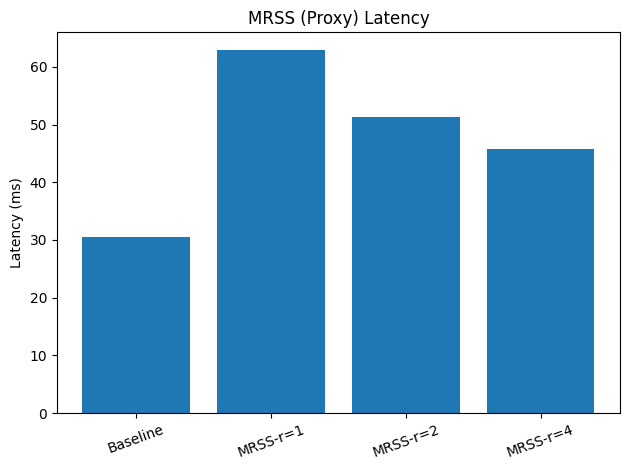

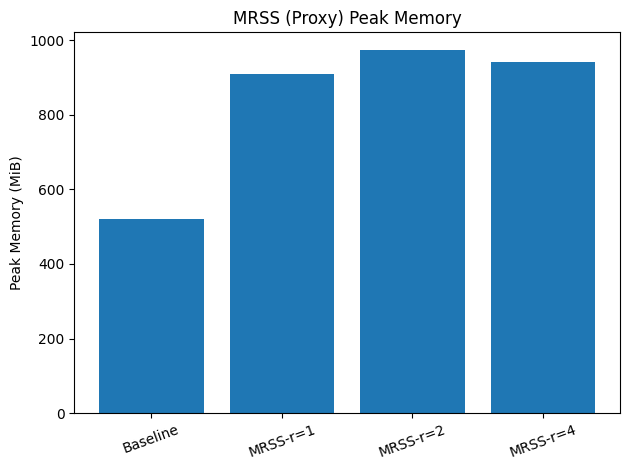

In [4]:
labels = [r[0] for r in results]
lat = [r[2] for r in results]
mem = [r[4] for r in results]

plt.figure()
plt.bar(labels, lat)
plt.ylabel("Latency (ms)")
plt.title("MRSS (Proxy) Latency")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("ssm_results/mrss_proxy_latency.png", dpi=150)
print("Saved -> ssm_results/mrss_proxy_latency.png")

plt.figure()
plt.bar(labels, mem)
plt.ylabel("Peak Memory (MiB)")
plt.title("MRSS (Proxy) Peak Memory")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("ssm_results/mrss_proxy_memory.png", dpi=150)
print("Saved -> ssm_results/mrss_proxy_memory.png")